# House Prices 데이터 전처리 실습 (연습용)

이 노트북은 Kaggle House Prices 데이터셋(`House Prices - Advanced Regression Techniques.csv`)을 이용해
결측값 처리, 깊은 복사/얕은 복사, 이상치 탐색 등을 단계적으로 연습하기 위한 실습 문제 모음입니다.

## 학습 목표
1. 결측값 탐색과 처리
2. 수치형 vs 범주형 컬럼 별로 다른 방식의 결측값 대체
3. 얕은 복사(shallow copy)와 깊은 복사(deep copy)의 차이
4. 이상치(outlier) 탐지 및 제거 (IQR 방식)
5. 전처리 파이프라인 구성 및 전/후 비교

아래 셀을 먼저 실행해서 데이터를 불러오세요.

In [5]:
!pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 9.6 MB/s  0:00:00m 9.8 MB/s eta 0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 9.2 MB/s  0:00:00m 9.9 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 9.5 MB/s  0:00:00m 9.8 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [matplotlib] 6/7 [matplotlib]ow]


In [7]:
!pip install seaborn

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터 불러오기
df = pd.read_csv("../05_House Prices - Advanced Regression Techniques.csv")

df.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 문제 1️⃣: 데이터 구조 파악하기
- 데이터의 행/열 수(shape)를 확인하세요.
- 주요 수치형 변수들의 기본 통계(describe())를 확인하세요.
- info()를 통해 각 컬럼의 결측 여부와 타입을 확인하세요.

In [3]:
# TODO: df.shape, df.describe(), df.info() 등을 이용해 데이터 구조를 살펴보세요.

In [38]:
# (1)데이터프레임 원본의 크기: 1460행, 81열의 데이터 구조를 가지고 있다.
df.shape

(1460, 81)

In [39]:
# (2)전체 컬럼의 수: 11 rows × 81 columns
df.describe(include='all')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,1460.000000,1460.000000,1460,1201.000000,1460.000000,1460,91,1460,1460,1460,...,1460.000000,7,281,54,1460.000000,1460.000000,1460.000000,1460,1460,1460.000000
unique,NaN,NaN,5,NaN,NaN,2,2,4,4,2,...,NaN,3,4,4,NaN,NaN,NaN,9,6,NaN
top,NaN,NaN,RL,NaN,NaN,Pave,Grvl,Reg,Lvl,AllPub,...,NaN,Gd,MnPrv,Shed,NaN,NaN,NaN,WD,Normal,NaN
freq,NaN,NaN,1151,NaN,NaN,1454,50,925,1311,1459,...,NaN,3,157,49,NaN,NaN,NaN,1267,1198,NaN
mean,730.500000,56.897260,NaN,70.049958,10516.828082,NaN,NaN,NaN,NaN,NaN,...,2.758904,NaN,NaN,NaN,43.489041,6.321918,2007.815753,NaN,NaN,180921.195890
std,421.610009,42.300571,NaN,24.284752,9981.264932,NaN,NaN,NaN,NaN,NaN,...,40.177307,NaN,NaN,NaN,496.123024,2.703626,1.328095,NaN,NaN,79442.502883
min,1.000000,20.000000,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,1.000000,2006.000000,NaN,NaN,34900.000000
25%,365.750000,20.000000,NaN,59.000000,7553.500000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,5.000000,2007.000000,NaN,NaN,129975.000000
50%,730.500000,50.000000,NaN,69.000000,9478.500000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,6.000000,2008.000000,NaN,NaN,163000.000000
75%,1095.250000,70.000000,NaN,80.000000,11601.500000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,8.000000,2009.000000,NaN,NaN,214000.000000


In [40]:
# (3)수치형 컬럼의 수: 8 rows × 38 columns
df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [41]:
# (4)문자열(범주형) 컬럼의 수: 4 rows × 43 columns
df.describe(include='object')

/var/folders/m5/7lqdcr0s3l34ctqrydvqgpn80000gn/T/ipykernel_43411/3256261912.py:2: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  df.describe(include='object')


,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


In [42]:
# (5)
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   str    
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   str    
 6   Alley          91 non-null     str    
 7   LotShape       1460 non-null   str    
 8   LandContour    1460 non-null   str    
 9   Utilities      1460 non-null   str    
 10  LotConfig      1460 non-null   str    
 11  LandSlope      1460 non-null   str    
 12  Neighborhood   1460 non-null   str    
 13  Condition1     1460 non-null   str    
 14  Condition2     1460 non-null   str    
 15  BldgType       1460 non-null   str    
 16  HouseStyle     1460 non-null   str    
 17  OverallQual    1460 non-null   int64  
 18  OverallCond    1460

## 문제 2️⃣: 결측값 개수 확인하기
- 각 컬럼별 결측값(null) 개수를 계산하고, 많은 순으로 정렬하여 상위 10개를 출력하세요.
- 어떤 컬럼들이 결측이 심한지 파악하세요.

In [3]:
# TODO: 각 컬럼별 결측값 개수를 세고 상위 10개를 출력하세요.

In [43]:
# (1)데이터프레임의 모든 셀을 검사

df.isnull()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,False,False,False,False,False,False,True,False,False,False,...,False,True,True,True,False,False,False,False,False,False
1,False,False,False,False,False,False,True,False,False,False,...,False,True,True,True,False,False,False,False,False,False
2,False,False,False,False,False,False,True,False,False,False,...,False,True,True,True,False,False,False,False,False,False
3,False,False,False,False,False,False,True,False,False,False,...,False,True,True,True,False,False,False,False,False,False
4,False,False,False,False,False,False,True,False,False,False,...,False,True,True,True,False,False,False,False,False,False
5,False,False,False,False,False,False,True,False,False,False,...,False,True,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,True,False,False,False,...,False,True,True,True,False,False,False,False,False,False
7,False,False,False,True,False,False,True,False,False,False,...,False,True,True,False,False,False,False,False,False,False
8,False,False,False,False,False,False,True,False,False,False,...,False,True,True,True,False,False,False,False,False,False
9,False,False,False,False,False,False,True,False,False,False,...,False,True,True,True,False,False,False,False,False,False


In [45]:
# (2)
# 컬럼별로 결측치 개수(True의 개수)를 합산
# Python에서 True=1, False=0으로 취급되기 때문에 합계 = 결측치 개수

df.isnull().sum()

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType        872
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFin

In [46]:
# (3)전체 컬럼의 결측치 개수(True 개수)를 합산

pd.set_option('display.max_rows', None)
df.isnull().sum()

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType        872
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFin

In [48]:
# (4)전체 컬럼의 결측치 확인
# scending=False → 내림차순

df.isnull().sum().sort_values(ascending=False)

PoolQC           1453
MiscFeature      1406
Alley            1369
Fence            1179
MasVnrType        872
FireplaceQu       690
LotFrontage       259
GarageYrBlt        81
GarageCond         81
GarageType         81
GarageFinish       81
GarageQual         81
BsmtFinType2       38
BsmtExposure       38
BsmtQual           37
BsmtCond           37
BsmtFinType1       37
MasVnrArea          8
Electrical          1
Id                  0
Functional          0
Fireplaces          0
KitchenQual         0
KitchenAbvGr        0
BedroomAbvGr        0
HalfBath            0
FullBath            0
BsmtHalfBath        0
TotRmsAbvGrd        0
GarageCars          0
GrLivArea           0
GarageArea          0
PavedDrive          0
WoodDeckSF          0
OpenPorchSF         0
EnclosedPorch       0
3SsnPorch           0
ScreenPorch         0
PoolArea            0
MiscVal             0
MoSold              0
YrSold              0
SaleType            0
SaleCondition       0
BsmtFullBath        0
HeatingQC 

In [49]:
# (5)전체 컬럼의 결측치 확인
# 내림차순 => scending=False
# 상위 10개 => head(10)

df.isnull().sum().sort_values(ascending=False).head(10)

PoolQC         1453
MiscFeature    1406
Alley          1369
Fence          1179
MasVnrType      872
FireplaceQu     690
LotFrontage     259
GarageYrBlt      81
GarageCond       81
GarageType       81
dtype: int64

## 문제 3️⃣: 결측 비율(%) 확인하기
- 각 컬럼별 결측 비율(결측 개수 / 전체 행 수 * 100)을 구한 뒤,
  비율이 높은 순서대로 정렬하여 상위 10개를 시각화(barh)하세요.
- 그래프 제목: `결측 비율 상위 컬럼`

In [2]:
# TODO: 결측 비율 상위 10개 컬럼을 barh로 시각화하세요.

In [65]:
# (1)각 컬럼별 결측 비율 상위 10개 컬럼
# 비율을 구하고 => 정렬 하고 => 상위 10개 추출

(df.isnull().sum() / len(df) * 100).sort_values(ascending=False).head(10)

PoolQC         99.520548
MiscFeature    96.301370
Alley          93.767123
Fence          80.753425
MasVnrType     59.726027
FireplaceQu    47.260274
LotFrontage    17.739726
GarageYrBlt     5.547945
GarageCond      5.547945
GarageType      5.547945
dtype: float64

In [71]:
# mac 환경에서 'Malgun Gothic'폰트가 없어서 에러가 발생했습니다.
# 그래서 AppleGothic을 사용했습니다.

import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

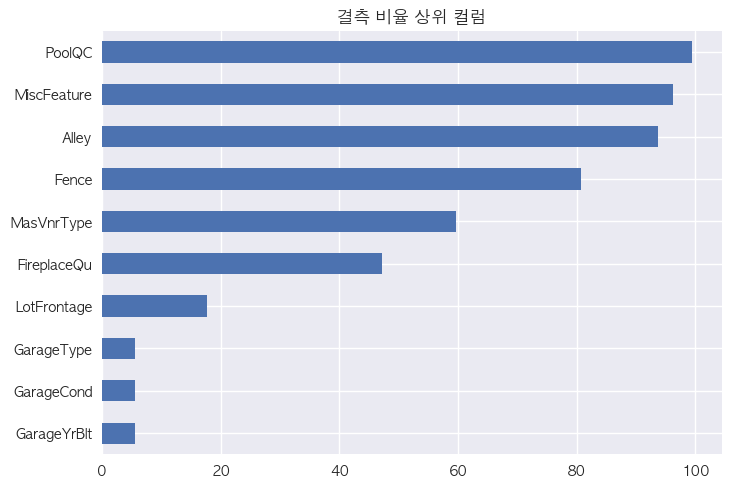

In [78]:
# (2)결측 비율 상위 10개 컬럼 시각화

# (2-1)각 컬럼별 결측 비율 missing_ratio
missing_ratio = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False).head(10)

# (2-2)시각화
# 그래프를 오름차순으로 정렬 => .sort_values(ascending=True)
# plot()의 kind 파라미터로 가로 막대 그래프 지정 => .plot(kind='barh')

missing_ratio.sort_values(ascending=True).plot(kind='barh')
plt.title("결측 비율 상위 컬럼")
plt.show()

## 문제 4️⃣: 수치형 결측값 처리 (LotFrontage 예시)
- `LotFrontage`는 땅이 도로와 맞닿은 길이입니다. 이 컬럼은 결측이 존재합니다.
- 1) 원본에서 `LotFrontage`의 평균(mean)과 중앙값(median)을 계산하세요.
- 2) `LotFrontage`의 결측을 **중앙값**으로 채운 새 DataFrame `df_numfilled`를 만드세요.
- 3) 채우기 전/후의 결측 개수를 비교하세요.

In [52]:
# TODO:
# 1) LotFrontage 평균/중앙값 계산
# 2) 중앙값으로 채운 df_numfilled 생성
# 3) 채우기 전/후 결측 개수 비교

In [83]:
# (1)LotFrontage 평균/중앙값 계산

print('* 평균: ',df['LotFrontage'].mean())
print('* 중앙값: ',df['LotFrontage'].median())

* 평균:  70.04995836802665
* 중앙값:  69.0


In [84]:
# (2)중앙값으로 채운 df_numfilled 생성

# (2-1)df 데이터를 df_numfilled로 복사
df_numfilled = df.copy()

# (2-2)df_numfilled를 중앙값으로 채우기
df_numfilled['LotFrontage'] = df_numfilled['LotFrontage'].fillna(df['LotFrontage'].median())

In [85]:
# (3)채우기 전/후 결측 개수 비교

print('* 채우기 전: ', df['LotFrontage'].isnull().sum())
print('* 채우기 후: ', df_numfilled['LotFrontage'].isnull().sum())

* 채우기 전:  259
* 채우기 후:  0


## 문제 5️⃣: 범주형 결측값 처리 (GarageType 예시)
- `GarageType`은 차고의 형태(Attached, Detached 등)를 나타냅니다. 결측은 '차고 없음'일 가능성이 큽니다.
- 1) `GarageType`의 현재 고유값(value_counts(dropna=False))을 확인하세요.
- 2) 결측값을 문자열 `'None'`으로 채운 새 DataFrame `df_catfilled`를 만드세요.
- 3) 채우기 전/후 결측 개수를 비교하세요.

In [86]:
# TODO:
# 1) GarageType value_counts(dropna=False)
# 2) 결측을 'None'으로 채운 df_catfilled 생성
# 3) 전/후 결측 개수 비교

In [92]:
# (1)GarageType의 현재 고유값(value_counts(dropna=False))을 확인

# dropna=False => 결측(NaN)도 개수에 포함시켜서 보여준다.
df['GarageType'].value_counts(dropna=False)

GarageType
Attchd     870
Detchd     387
BuiltIn     88
NaN         81
Basment     19
CarPort      9
2Types       6
Name: count, dtype: int64

In [90]:
# dropna=True => 결측(NaN)은 생격하여 보여준다.
df['GarageType'].value_counts(dropna=True)

GarageType
Attchd     870
Detchd     387
BuiltIn     88
Basment     19
CarPort      9
2Types       6
Name: count, dtype: int64

In [93]:
# (2)결측값을 문자열 'None'으로 채운 새 DataFrame df_catfilled를 만들기

# (2-1)df 데이터를 df_catfilled로 복사
df_catfilled = df.copy()

# (2-2)
df_catfilled['GarageType'] = df_catfilled['GarageType'].fillna('None')

In [94]:
# (3)채우기 전/후 결측 개수를 비교

print('* 채우기 전: ', df['GarageType'].isnull().sum())
print('* 채우기 후: ', df_catfilled['GarageType'].isnull().sum())

* 채우기 전:  81
* 채우기 후:  0


## 문제 6️⃣: 전체 결측 처리 버전 만들기
- 다음 규칙으로 새로운 DataFrame `df_filled`를 만드세요.
  - 수치형 컬럼은 중앙값(median)으로 채운다.
  - 범주형 컬럼(object 타입)은 `'Unknown'`으로 채운다.
- 그런 다음 df_filled에 남아있는 결측값 개수를 모두 합산하여 출력하세요.

In [95]:
# TODO:
# df_filled를 만들고 수치형=중앙값, 범주형='Unknown'으로 채운 뒤
# 남은 결측 총합을 출력하세요.

In [97]:
# (1)
# (1-1)새로운 DataFrame df_filled를 만든다.

df_filled = df.copy()

In [103]:
# (1-2)수치형 컬럼은 중앙값(median)으로 채운다.

# 수치형 컬럼들을 num_cols 변수에 넣는다.
num_cols = df_filled.select_dtypes(include='number').columns

# 수치형 컬럼들을 중앙값(median)으로 채운다.
df_filled[num_cols] = df_filled[num_cols].fillna(df[num_cols].median())

In [107]:
# (1-3)범주형 컬럼(object 타입)은 'Unknown'으로 채운다.

# 수치형 컬럼들을 num_cols 변수에 넣는다.
cat_cols = df_filled.select_dtypes(include='str').columns

# 범주형 컬럼들을 중앙값(median)으로 채운다.
df_filled[cat_cols] = df_filled[cat_cols].fillna('Unknown')

In [110]:
# (2)df_filled에 남아있는 결측값 개수를 모두 합산하여 출력.

print('* 남음 결측값: ', df_filled.isnull().sum().sum())

* 남음 결측값:  0


## 문제 7️⃣: 얕은 복사 vs 깊은 복사
- 얕은 복사(shallow copy)와 깊은 복사(deep copy)의 차이를 관찰해봅니다.
- 1) `df_shallow = df` 로 얕은 복사를 만드세요.
- 2) `df_deep = df.copy()` 로 깊은 복사를 만드세요.
- 3) 얕은 복사 쪽의 특정 컬럼(예: `LotArea`) 값을 변경했을 때 원본 df도 함께 바뀌는지 확인하세요.
- 4) 깊은 복사쪽은 독립적인지 확인하세요.

In [111]:
# TODO:
# df_shallow = df
# df_deep = df.copy()
# df_shallow의 LotArea 첫 값을 수정하고 df/deep 비교하세요.
# (실습 후 원복도 시도해보세요.)

In [119]:
# (1)df_shallow = df 로 얕은 복사를 

df_shallow = df

In [120]:
# (2)df_deep = df.copy() 로 깊은 복사를

df_deep = df.copy()

In [125]:
# (3)

# (3-1)
print('* 변경 전 원본: ', df['LotArea'][0])

# (3-2)
df_shallow['LotArea'][0] = 99999

# (3-3)
print('* 변경 후 원본: ', df['LotArea'][0])

* 변경 전 원본:  8450
* 변경 후 원본:  8450


/var/folders/m5/7lqdcr0s3l34ctqrydvqgpn80000gn/T/ipykernel_43411/3652341790.py:7: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

Try using '.loc[row_indexer, col_indexer] = value' instead, to perform the assignment in a single step.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html#chained-assignment
  df_shallow['LotArea'][0] = 99999


In [122]:
df_deep['LotArea'][0] = 11111

/var/folders/m5/7lqdcr0s3l34ctqrydvqgpn80000gn/T/ipykernel_43411/2708881368.py:1: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

Try using '.loc[row_indexer, col_indexer] = value' instead, to perform the assignment in a single step.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html#chained-assignment
  df_deep['LotArea'][0] = 11111


In [124]:
# (4)

# (4-1)깊은 복사 값 변경
df_deep['LotArea'][0] = 11111

# (4-2)원본 확인
print('* 원본: ', df['LotArea'][0])
print('* 깊은 복사: ', df_deep['LotArea'][0])

* 원본:  8450
* 깊은 복사:  8450


/var/folders/m5/7lqdcr0s3l34ctqrydvqgpn80000gn/T/ipykernel_43411/872821439.py:4: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

Try using '.loc[row_indexer, col_indexer] = value' instead, to perform the assignment in a single step.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html#chained-assignment
  df_deep['LotArea'][0] = 11111
